# Pixel pseudophenotyping

- Jacopo Umberto Verga
- 08/14/2024


After pre-processing the images
- [steinbock](https://bodenmillergroup.github.io/steinbock/latest/) extract tiff files
- Extract single channel files with [imagej](https://imagej.net/ij/) and python
- Registering each slide with [skimage](https://scikit-image.org/)
- Pixel cleaning

We are going to pseudophenotype our pixels, first try with:

# Pre-trained XGBoost classifier:

We already trained a classifier to cell type annotation who takes a set of features (markers) and predict the major cell type.

In [1]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import pandas as pd
import scanpy as sc
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
adata=sc.read('./samples/adata_clean.h5ad')

In [3]:
with open("model/XGB_classifier.pkl", "rb") as f:
    model = pickle.load(f)
with open("model/XGB_classifier_label-encoder.pkl", "rb") as f:
    le = pickle.load(f)


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:45:24] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [4]:
features=list(model.feature_names_in_)
print(features)

['Ki-67', 'aSMA', 'CCR4', 'CD14', 'TIM-3', 'CD16', 'CD163', 'CD11b', 'CD31', 'BCMA', 'CD11c', 'CD4', 'CD68', 'CD117', 'CD20', 'CD8', 'CCR6', 'CD56', 'CD138', 'Granzyme_B', 'CD127', 'CD3', 'CD27', 'TIGIT', 'CCR7', 'HLA-DR', 'CD45RO']


In [5]:
df=sc.get.obs_df(adata, features, layer='exprs')
df.head()

,Ki-67,aSMA,CCR4,CD14,TIM-3,CD16,CD163,CD11b,CD31,BCMA,...,CD56,CD138,Granzyme_B,CD127,CD3,CD27,TIGIT,CCR7,HLA-DR,CD45RO
283_186_1_D0246,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.158944,0.000000,0.000000,0.000000,...,0.158944,0.000000,0.158944,0.000000,0.000000,0.260340,0.000000,0.000000,0.000000,0.000000
284_186_1_D0246,0.0,0.0,0.0,0.000000,0.000000,0.158944,0.158944,0.000000,0.158944,0.260340,...,0.158944,0.260340,0.260340,0.158944,0.158944,0.327932,0.260340,0.158944,0.000000,0.000000
285_186_1_D0246,0.0,0.0,0.0,0.158944,0.158944,0.327932,0.158944,0.158944,0.327932,0.327932,...,0.260340,0.377753,0.260340,0.327932,0.327932,0.417017,0.417017,0.327932,0.158944,0.158944
286_186_1_D0246,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.158944,0.000000,0.000000,0.158944,0.000000,0.158944,0.158944,0.158944,0.158944,0.000000
283_187_1_D0246,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.158944,0.000000,0.000000,0.000000,0.158944,0.158944,0.000000,0.000000,0.000000


In [6]:
classes=model.predict(df)

In [7]:
cell_labels = pd.DataFrame(le.inverse_transform(classes))
cell_labels.index = df.index
cell_labels.columns = ['major_celltype']

In [8]:
props = pd.DataFrame(cell_labels.value_counts())
props = props.reset_index()

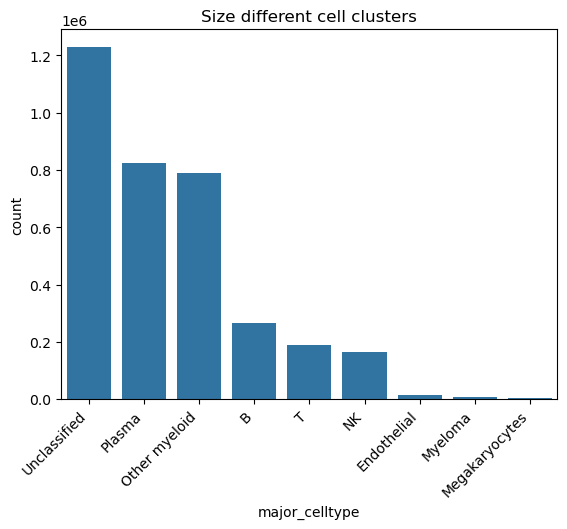

In [9]:
plt.figure()
sns.barplot(data=props, x=props['major_celltype'], y=props['count'])
plt.xticks(rotation=45, ha='right')
plt.title('Size different cell clusters')
plt.show()

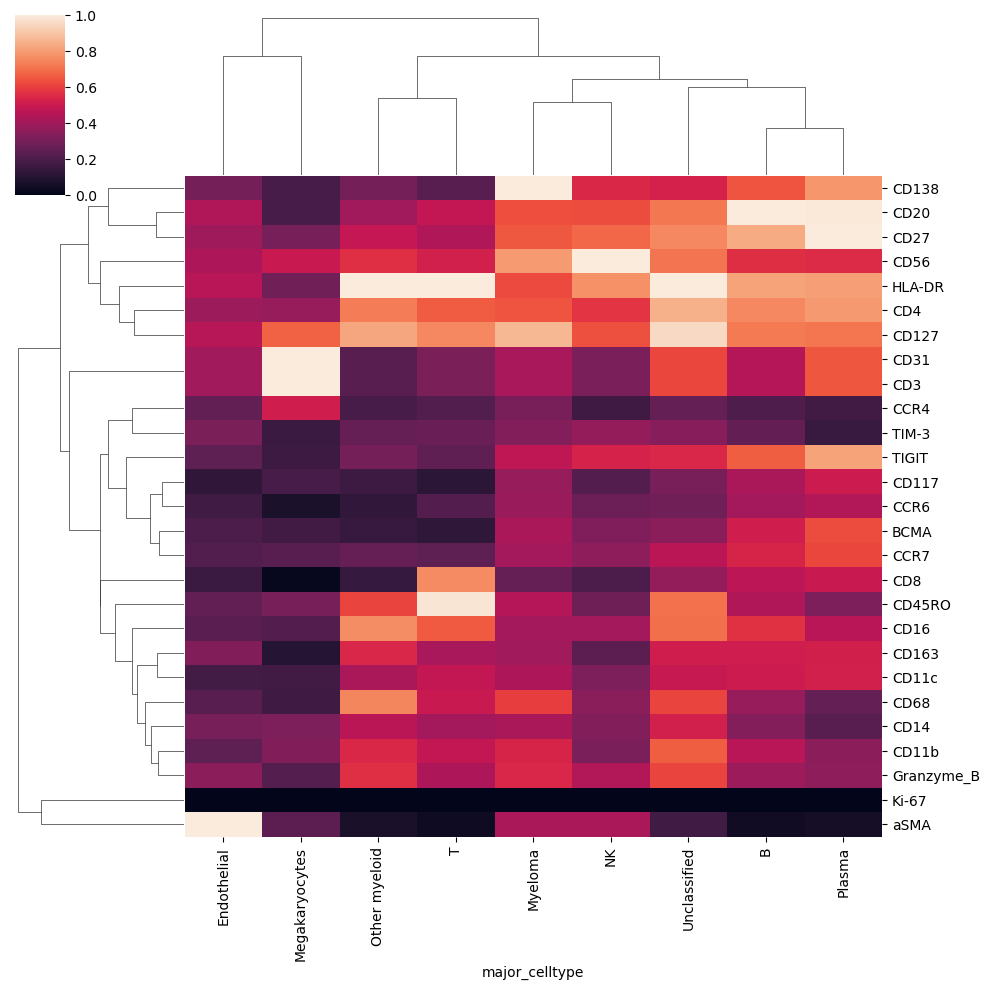

In [10]:
sns.clustermap(pd.concat([df,cell_labels],axis=1).groupby(by='major_celltype').mean().T,standard_scale=1)

# Refine Clustering

Similarly to the 2D dta we are going to refine the clustering using GMM

## Unclassified

In [11]:
adata.obs['major_pixel_type'] = cell_labels

In [12]:
def get_df_oi(adata,features_oi,pixel_type,column='major_pixel_type'):
    df=sc.get.obs_df(adata, keys=features_oi+[column],layer='exprs')
    df=df[df[column]==pixel_type]
    return df

In [13]:
from gmm.gmm import GMMCluster

In [17]:
n_components_range = range(2, 10)
covariance_types = ['full', 'tied', 'diag', 'spherical']
features_oi=['CD3','CD19','CD68','CD138','CD56','aSMA']
pixel_type='Unclassified'
df=get_df_oi(adata,features_oi,pixel_type)[features_oi]
mat=df.values

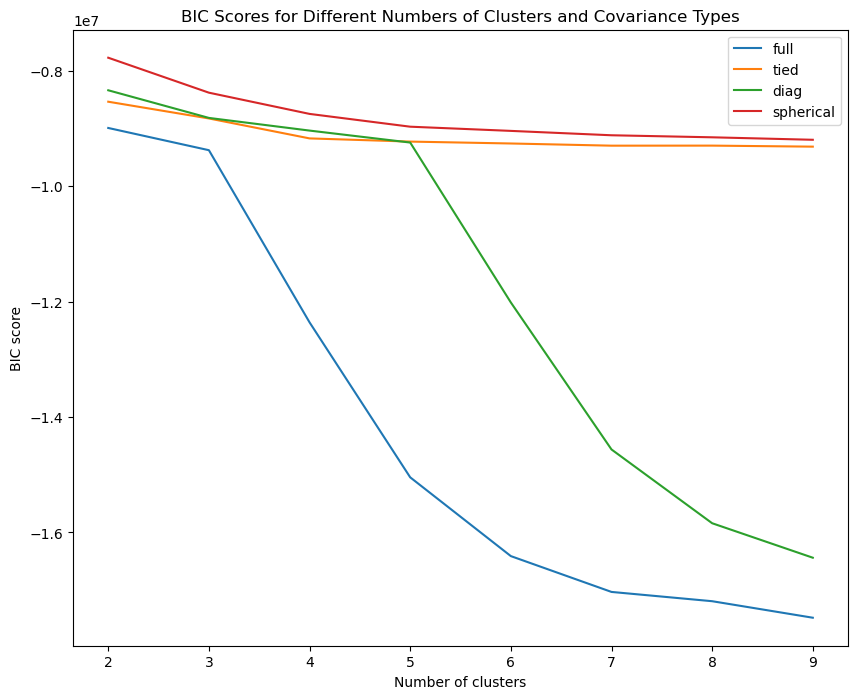

In [18]:
gmm=GMMCluster.get_best_gmm(mat=mat,
                            n_components_range=n_components_range,
                            covariance_types=covariance_types,
                            plot=True)

<Figure size 640x480 with 0 Axes>

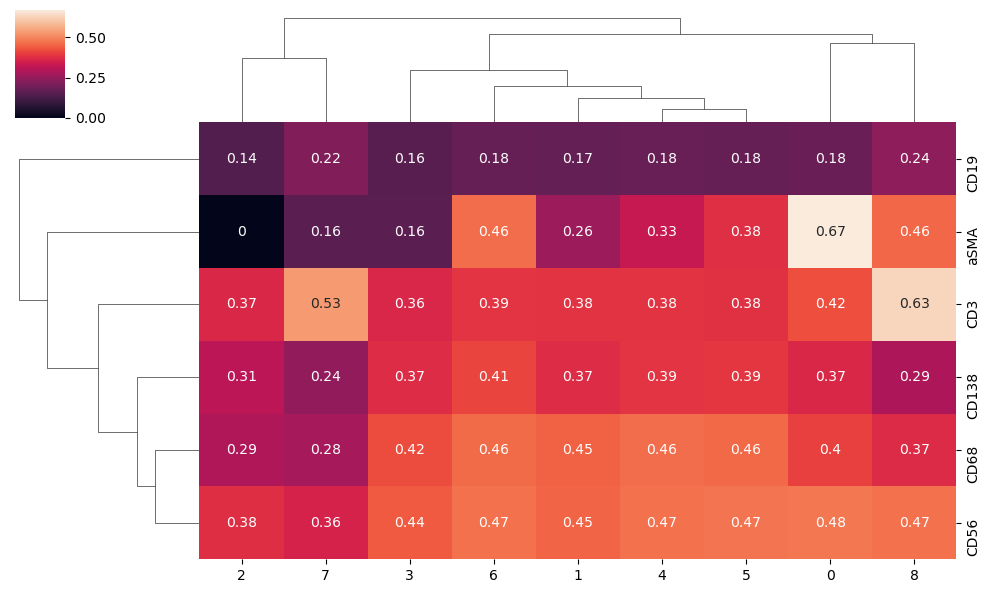

In [38]:
clusters = gmm.predict(mat)
means=pd.DataFrame(gmm.means_,columns=features_oi)

plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

<Figure size 640x480 with 0 Axes>

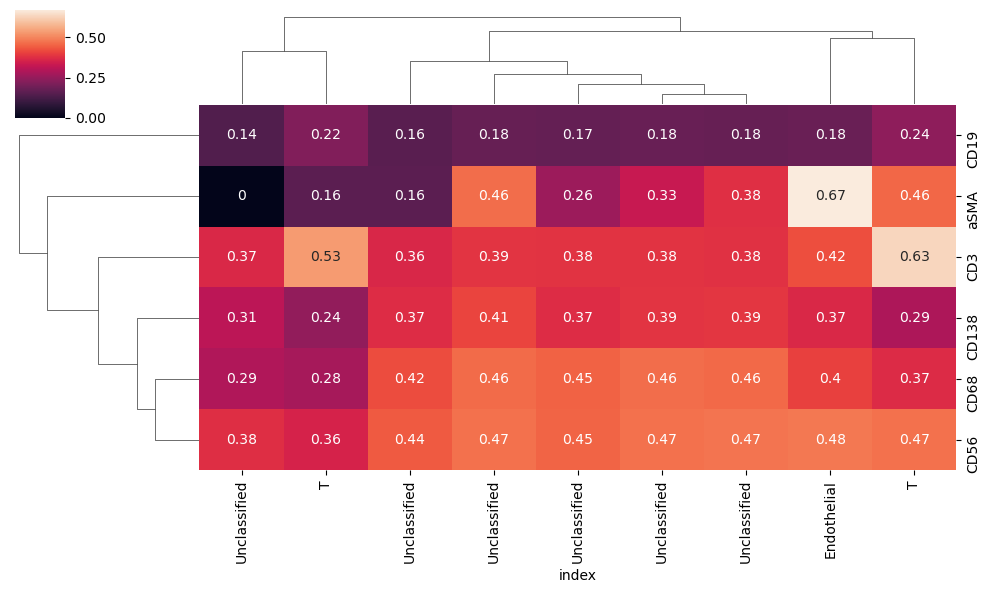

In [41]:
map_clusters={0:'Endothelial',
              1:'Unclassified',
              2:'Unclassified',
              3:'Unclassified',
              4:'Unclassified',
              5:'Unclassified',
              6:'Unclassified',
              7:'T',
              8:'T'
             }

means = means.reset_index()
means.index = means['index'].replace(map_clusters)
means = means.drop('index',axis=1)
plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

In [44]:
clusters_df=pd.DataFrame(clusters,index=df.index)[0].replace(map_clusters)
adata.obs.loc[clusters_df.index, 'major_pixel_type'] = clusters_df

In [49]:
n_components_range = range(2, 10)
covariance_types = ['full', 'tied', 'diag', 'spherical']
features_oi=['CD20','CD68','CD138','CD56']
pixel_type='Unclassified'
df=get_df_oi(adata,features_oi,pixel_type)[features_oi]
mat=df.values

In [50]:
gmm=GMMCluster.get_best_gmm(mat=mat,
                            n_components_range=n_components_range,
                            covariance_types=covariance_types,
                            plot=False)

<Figure size 640x480 with 0 Axes>

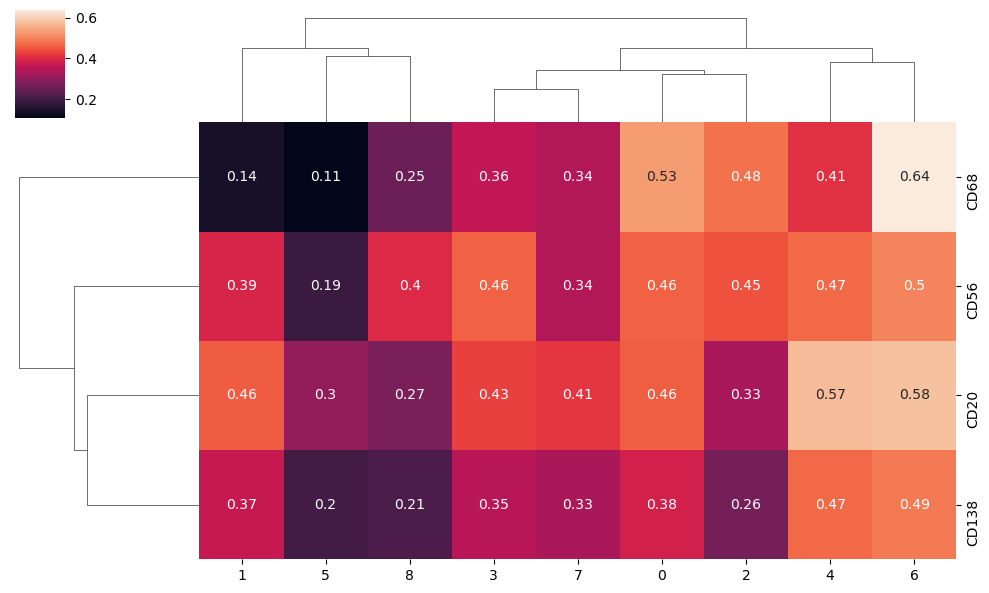

In [51]:
clusters = gmm.predict(mat)
means=pd.DataFrame(gmm.means_,columns=features_oi)

plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

<Figure size 640x480 with 0 Axes>

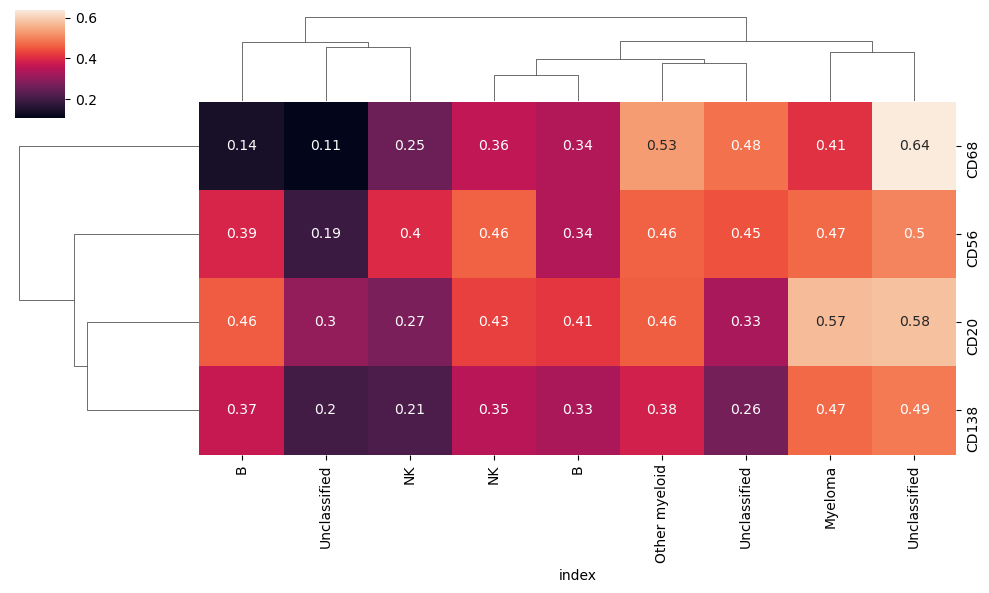

In [52]:
map_clusters={0:'Other myeloid',
              1:'B',
              2:'Unclassified',
              3:'NK',
              4:'Myeloma',
              5:'Unclassified',
              6:'Unclassified',
              7:'B',
              8:'NK'
             }

means = means.reset_index()
means.index = means['index'].replace(map_clusters)
means = means.drop('index',axis=1)
plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

In [53]:
clusters_df=pd.DataFrame(clusters,index=df.index)[0].replace(map_clusters)
adata.obs.loc[clusters_df.index, 'major_pixel_type'] = clusters_df

<Axes: xlabel='major_pixel_type'>

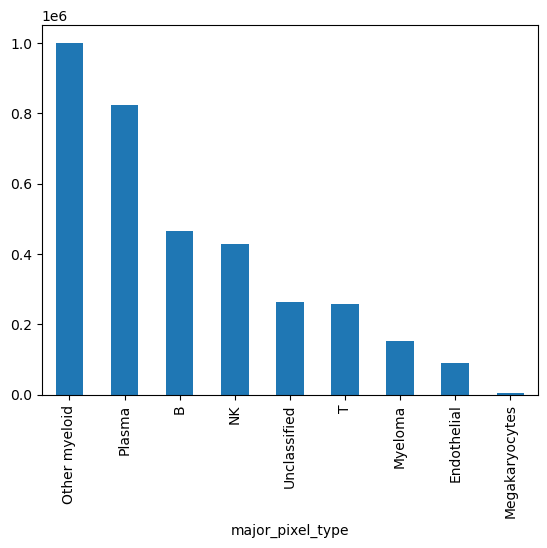

In [56]:
adata.obs['major_pixel_type'].value_counts().plot.bar()

## Other myeloid

In [59]:
n_components_range = range(2, 11)
covariance_types = ['full', 'tied', 'diag', 'spherical']
features_oi=['CD68','CD163','CD14','CD16', 'CD11b','CD11c']
pixel_type='Other myeloid'
df=get_df_oi(adata,features_oi,pixel_type)[features_oi]
mat=df.values

In [60]:
gmm=GMMCluster.get_best_gmm(mat=mat,
                            n_components_range=n_components_range,
                            covariance_types=covariance_types,
                            plot=False)

<Figure size 640x480 with 0 Axes>

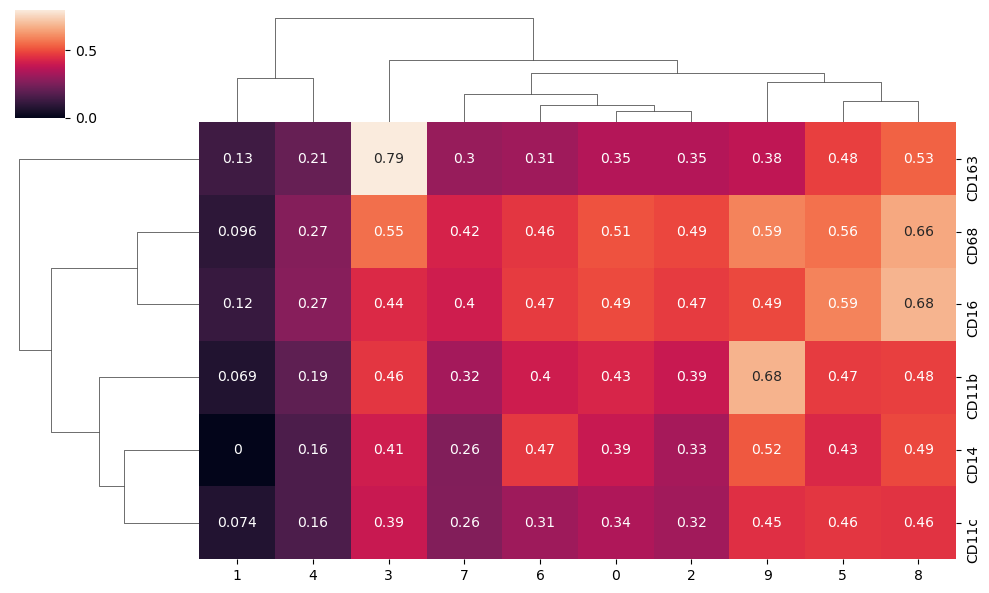

In [61]:
clusters = gmm.predict(mat)
means=pd.DataFrame(gmm.means_,columns=features_oi)

plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

<Figure size 640x480 with 0 Axes>

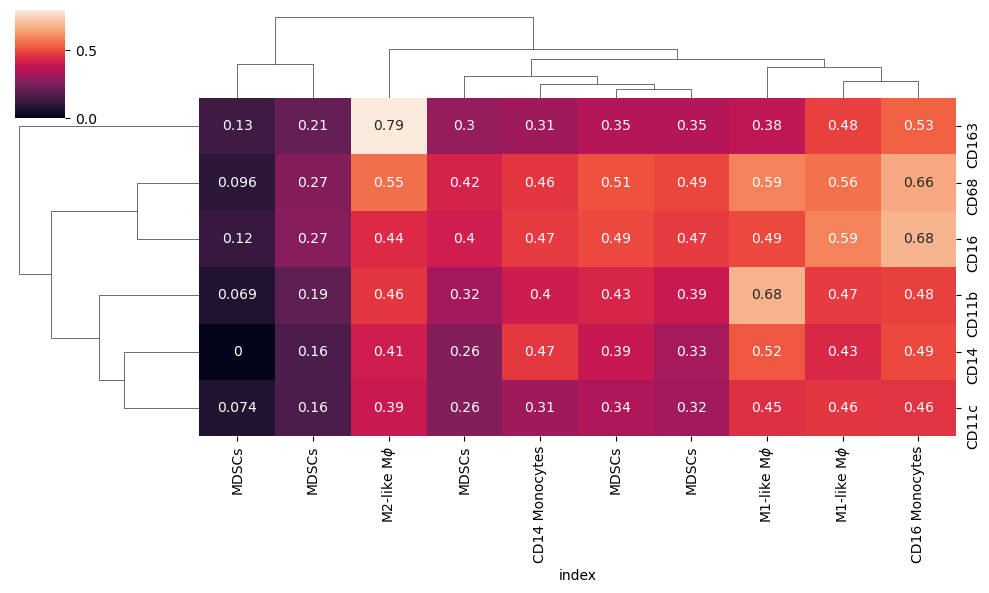

In [62]:
map_clusters={0:'MDSCs',
              1:'MDSCs',
              2:'MDSCs',
              3:'M2-like M$\\phi$',
              4:'MDSCs',
              5:'M1-like M$\\phi$',
              6:'CD14 Monocytes',
              7:'MDSCs',
              8:'CD16 Monocytes',
              9:'M1-like M$\\phi$'
             }

means = means.reset_index()
means.index = means['index'].replace(map_clusters)
means = means.drop('index',axis=1)
plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

In [63]:
clusters_df=pd.DataFrame(clusters,index=df.index)[0].replace(map_clusters)
adata.obs.loc[clusters_df.index, 'major_pixel_type'] = clusters_df

In [64]:
n_components_range = range(2, 11)
covariance_types = ['full', 'tied', 'diag', 'spherical']
features_oi=['CD68','CD163','CD11b','CD11c','HLA-DR']
pixel_type='MDSCs'
df=get_df_oi(adata,features_oi,pixel_type)[features_oi]
mat=df.values

In [65]:
gmm=GMMCluster.get_best_gmm(mat=mat,
                            n_components_range=n_components_range,
                            covariance_types=covariance_types,
                            plot=False)

<Figure size 640x480 with 0 Axes>

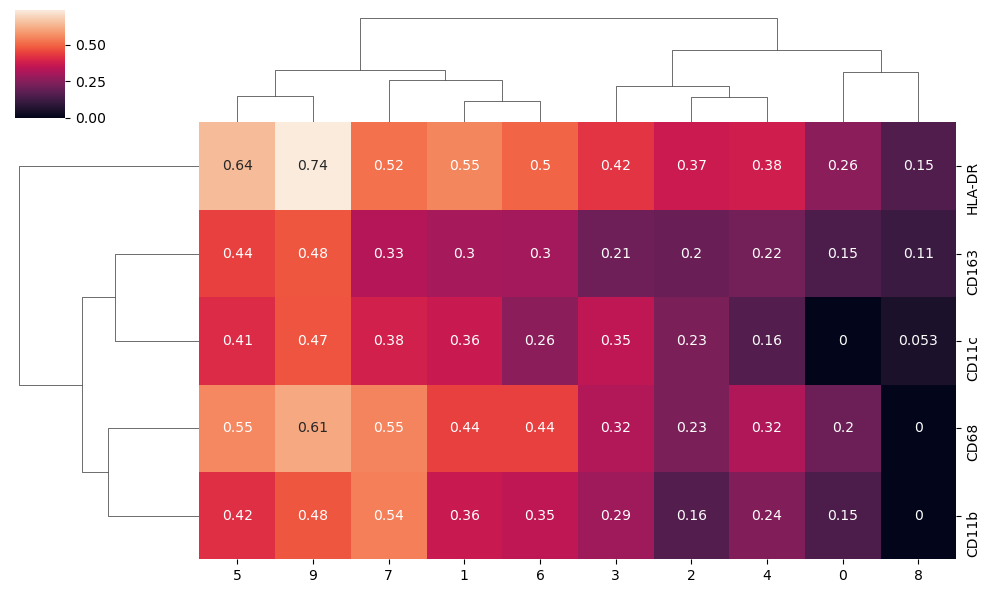

In [66]:
clusters = gmm.predict(mat)
means=pd.DataFrame(gmm.means_,columns=features_oi)

plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

<Figure size 640x480 with 0 Axes>

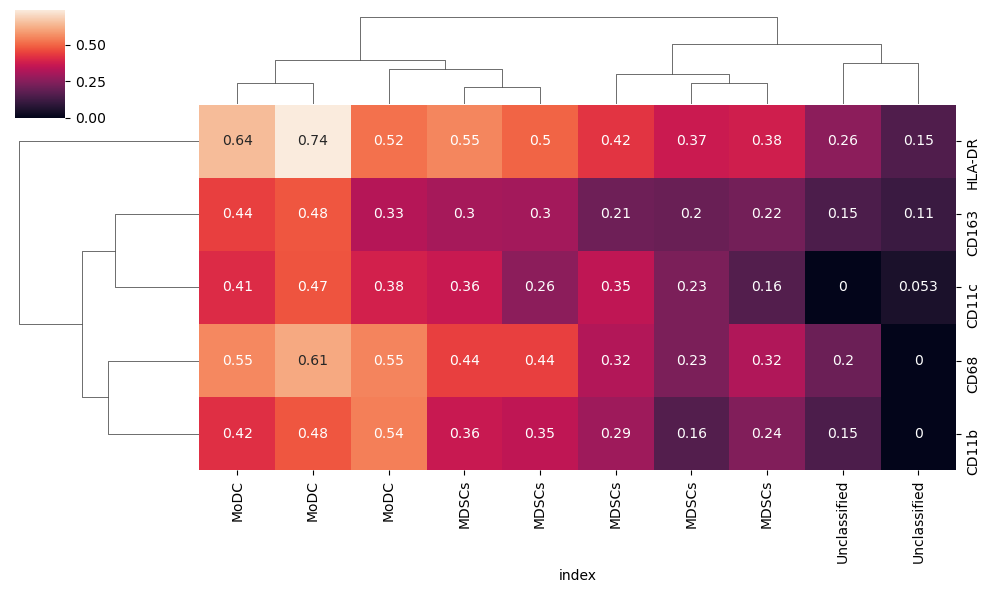

In [67]:
map_clusters={0:'Unclassified',
              1:'MDSCs',
              2:'MDSCs',
              3:'MDSCs',
              4:'MDSCs',
              5:'MoDC',
              6:'MDSCs',
              7:'MoDC',
              8:'Unclassified',
              9:'MoDC'
             }

means = means.reset_index()
means.index = means['index'].replace(map_clusters)
means = means.drop('index',axis=1)
plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

In [68]:
clusters_df=pd.DataFrame(clusters,index=df.index)[0].replace(map_clusters)
adata.obs.loc[clusters_df.index, 'major_pixel_type'] = clusters_df

<Axes: xlabel='major_pixel_type'>

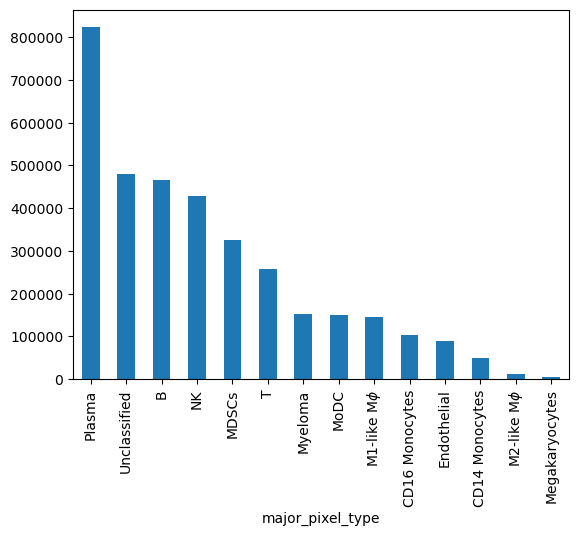

In [69]:
adata.obs['major_pixel_type'].value_counts().plot.bar()

## Plasma

In [70]:
n_components_range = range(2, 11)
covariance_types = ['full', 'tied', 'diag', 'spherical']
features_oi=['CD19','CD20','CD27','CD138']
pixel_type='Plasma'
df=get_df_oi(adata,features_oi,pixel_type)[features_oi]
mat=df.values

In [71]:
gmm=GMMCluster.get_best_gmm(mat=mat,
                            n_components_range=n_components_range,
                            covariance_types=covariance_types,
                            plot=False)

<Figure size 640x480 with 0 Axes>

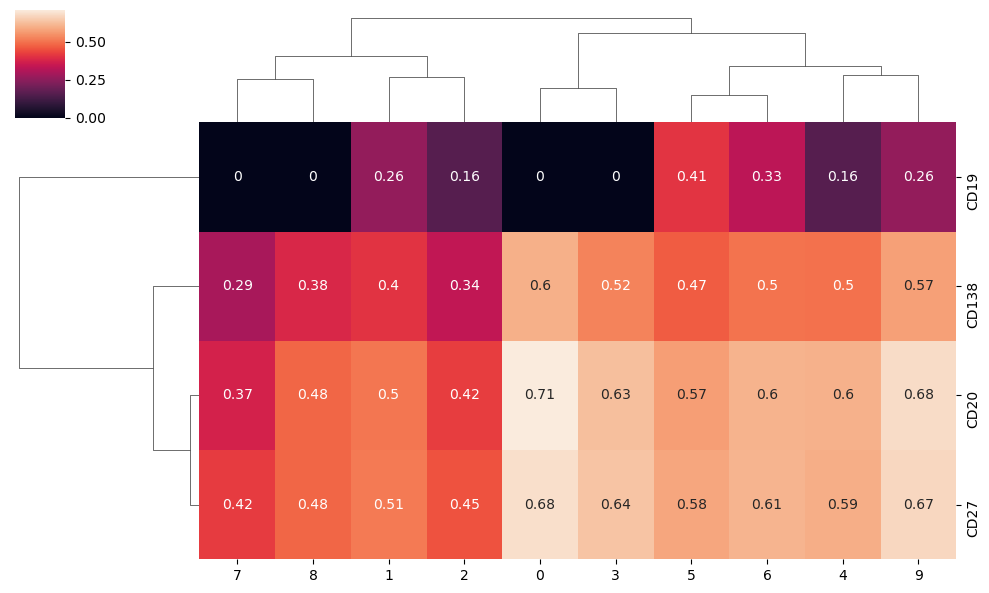

In [72]:
clusters = gmm.predict(mat)
means=pd.DataFrame(gmm.means_,columns=features_oi)

plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

<Figure size 640x480 with 0 Axes>

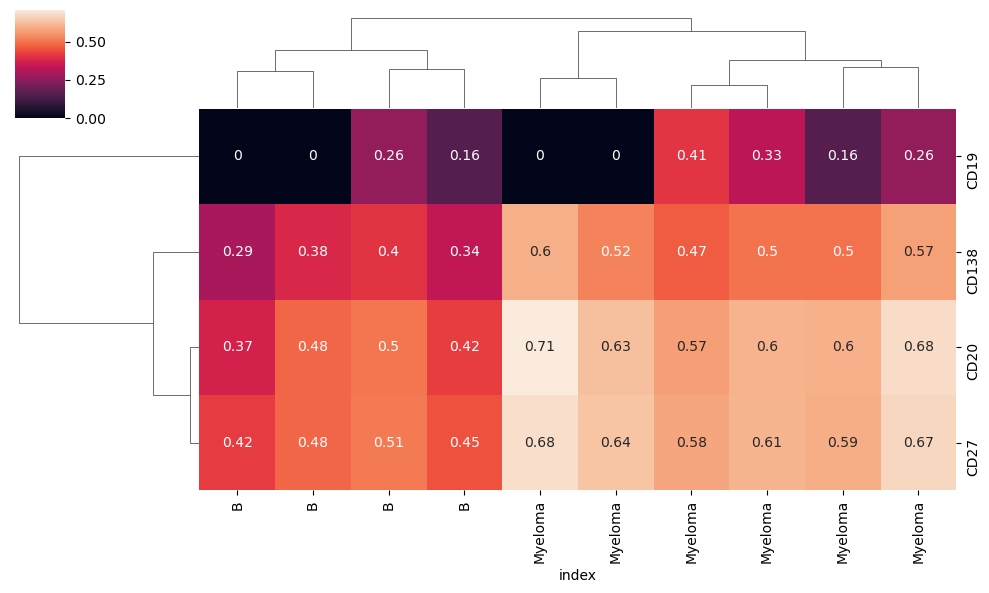

In [73]:
map_clusters={0:'Myeloma',
              1:'B',
              2:'B',
              3:'Myeloma',
              4:'Myeloma',
              5:'Myeloma',
              6:'Myeloma',
              7:'B',
              8:'B',
              9:'Myeloma'
             }

means = means.reset_index()
means.index = means['index'].replace(map_clusters)
means = means.drop('index',axis=1)
plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

In [74]:
clusters_df=pd.DataFrame(clusters,index=df.index)[0].replace(map_clusters)
adata.obs.loc[clusters_df.index, 'major_pixel_type'] = clusters_df

<Axes: xlabel='major_pixel_type'>

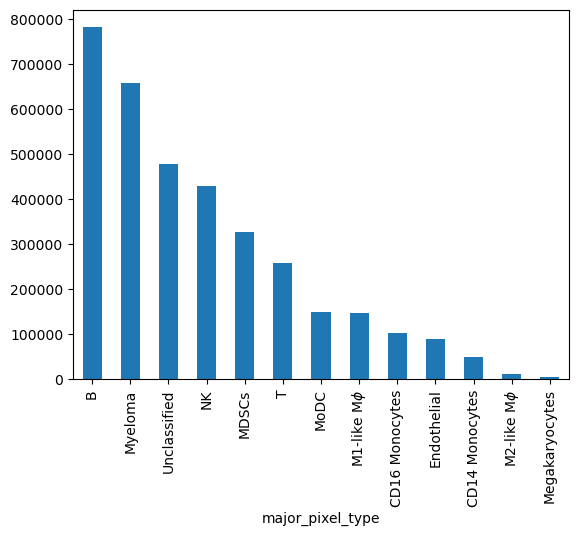

In [75]:
adata.obs['major_pixel_type'].value_counts().plot.bar()

## Unclassified

In [77]:
n_components_range = range(2, 11)
covariance_types = ['full', 'tied', 'diag', 'spherical']
features_oi=['CD20','CD3','CD68','aSMA']
pixel_type='Unclassified'
df=get_df_oi(adata,features_oi,pixel_type)[features_oi]
mat=df.values

In [78]:
gmm=GMMCluster.get_best_gmm(mat=mat,
                            n_components_range=n_components_range,
                            covariance_types=covariance_types,
                            plot=False)

<Figure size 640x480 with 0 Axes>

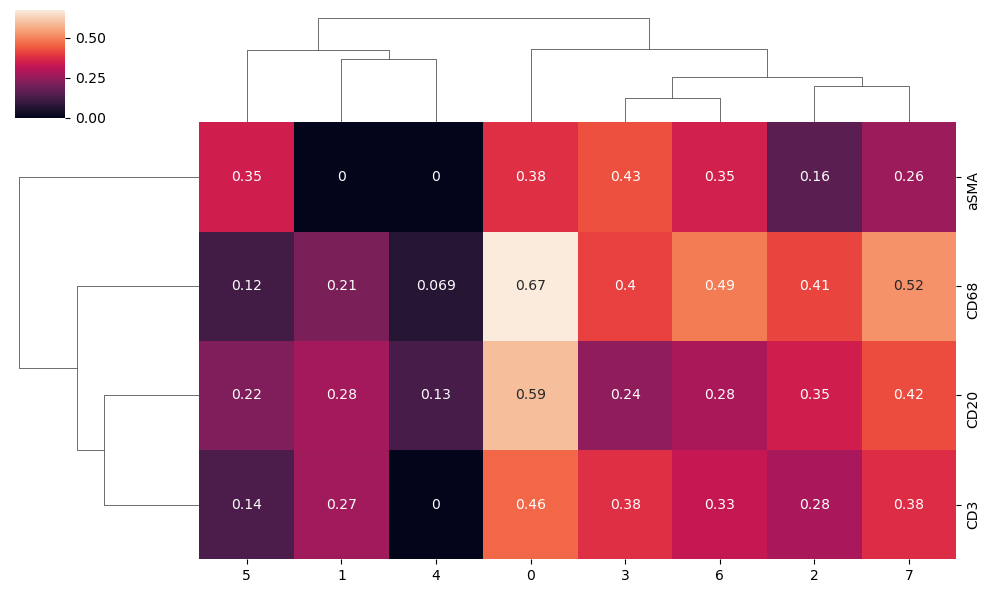

In [81]:
clusters = gmm.predict(mat)
means=pd.DataFrame(gmm.means_,columns=features_oi)

plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

<Figure size 640x480 with 0 Axes>

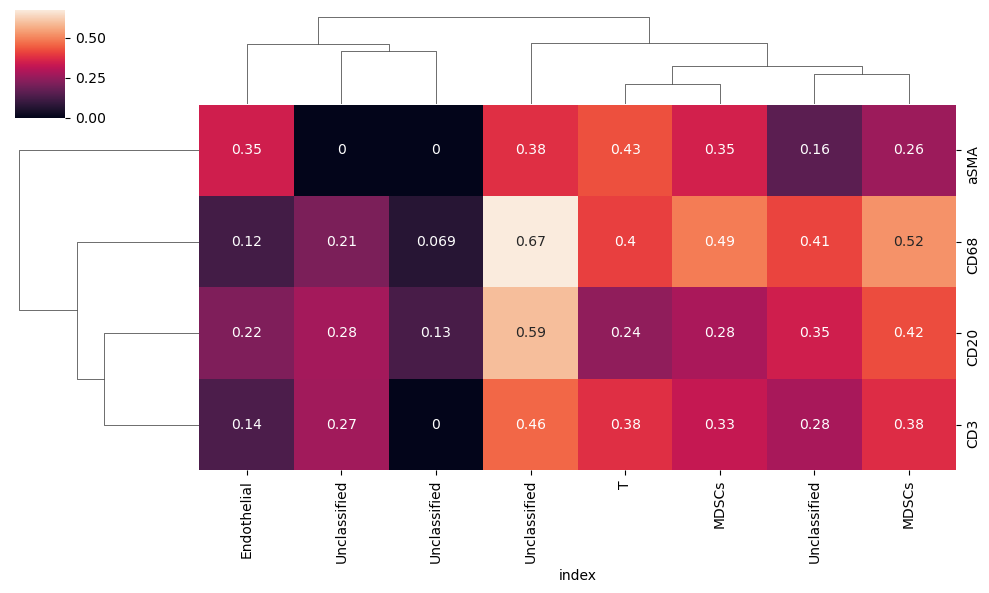

In [82]:
map_clusters={0:'Unclassified',
              1:'Unclassified',
              2:'Unclassified',
              3:'T',
              4:'Unclassified',
              5:'Endothelial',
              6:'MDSCs',
              7:'MDSCs'
             }

means = means.reset_index()
means.index = means['index'].replace(map_clusters)
means = means.drop('index',axis=1)
plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

In [83]:
clusters_df=pd.DataFrame(clusters,index=df.index)[0].replace(map_clusters)
adata.obs.loc[clusters_df.index, 'major_pixel_type'] = clusters_df

## T

In [86]:
n_components_range = range(2, 11)
covariance_types = ['full', 'tied', 'diag', 'spherical']
features_oi=['CD4','CD8','FoxP3','Granzyme_B','PD-1','TIM-3']
pixel_type='T'
df=get_df_oi(adata,features_oi,pixel_type)[features_oi]
mat=df.values

In [87]:
gmm=GMMCluster.get_best_gmm(mat=mat,
                            n_components_range=n_components_range,
                            covariance_types=covariance_types,
                            plot=False)

<Figure size 640x480 with 0 Axes>

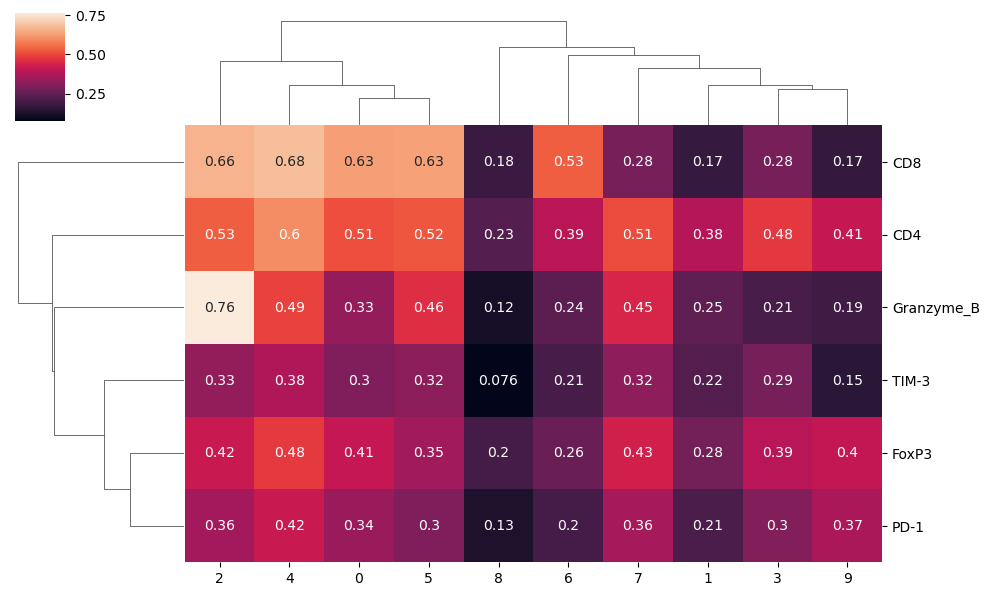

In [88]:
clusters = gmm.predict(mat)
means=pd.DataFrame(gmm.means_,columns=features_oi)

plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

<Figure size 640x480 with 0 Axes>

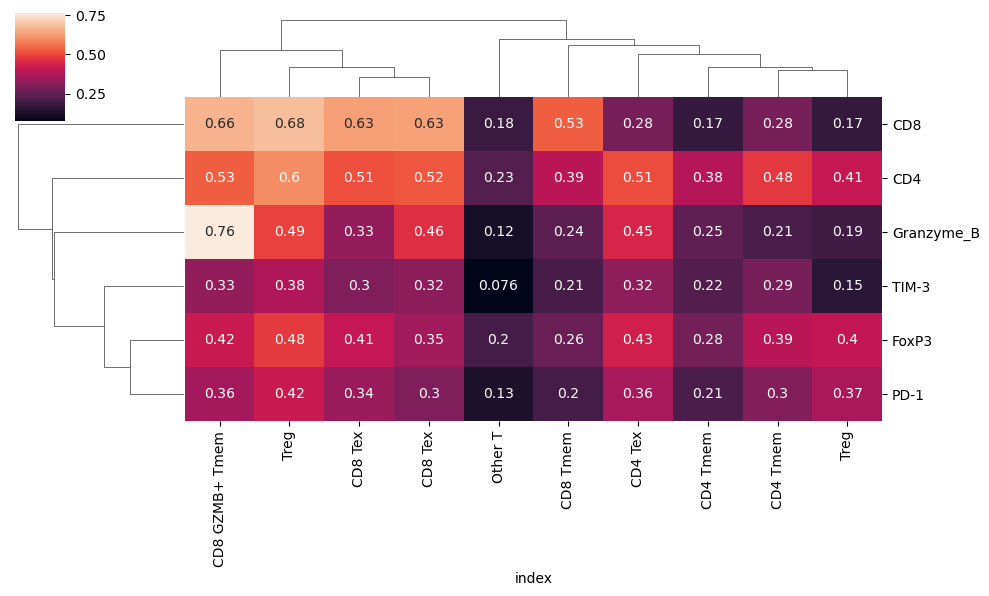

In [89]:
map_clusters={0:'CD8 Tex',
              1:'CD4 Tmem',
              2:'CD8 GZMB+ Tmem',
              3:'CD4 Tmem',
              4:'Treg',
              5:'CD8 Tex',
              6:'CD8 Tmem',
              7:'CD4 Tex',
              8:'Other T',
              9:'Treg'
             }

means = means.reset_index()
means.index = means['index'].replace(map_clusters)
means = means.drop('index',axis=1)
plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

In [90]:
clusters_df=pd.DataFrame(clusters,index=df.index)[0].replace(map_clusters)
adata.obs.loc[clusters_df.index, 'major_pixel_type'] = clusters_df

<Axes: xlabel='major_pixel_type'>

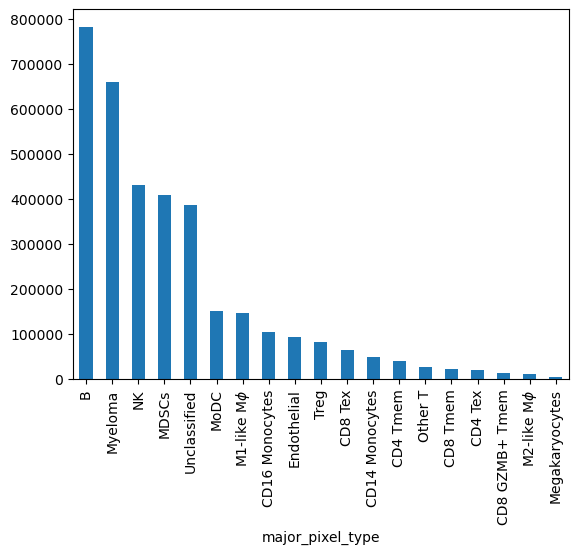

In [91]:
adata.obs['major_pixel_type'].value_counts().plot.bar()

## NK

In [93]:
n_components_range = range(2, 11)
covariance_types = ['full', 'tied', 'diag', 'spherical']
features_oi=['CD56','CD3','CD20','aSMA']
pixel_type='NK'
df=get_df_oi(adata,features_oi,pixel_type)[features_oi]
mat=df.values

In [94]:
gmm=GMMCluster.get_best_gmm(mat=mat,
                            n_components_range=n_components_range,
                            covariance_types=covariance_types,
                            plot=False)

<Figure size 640x480 with 0 Axes>

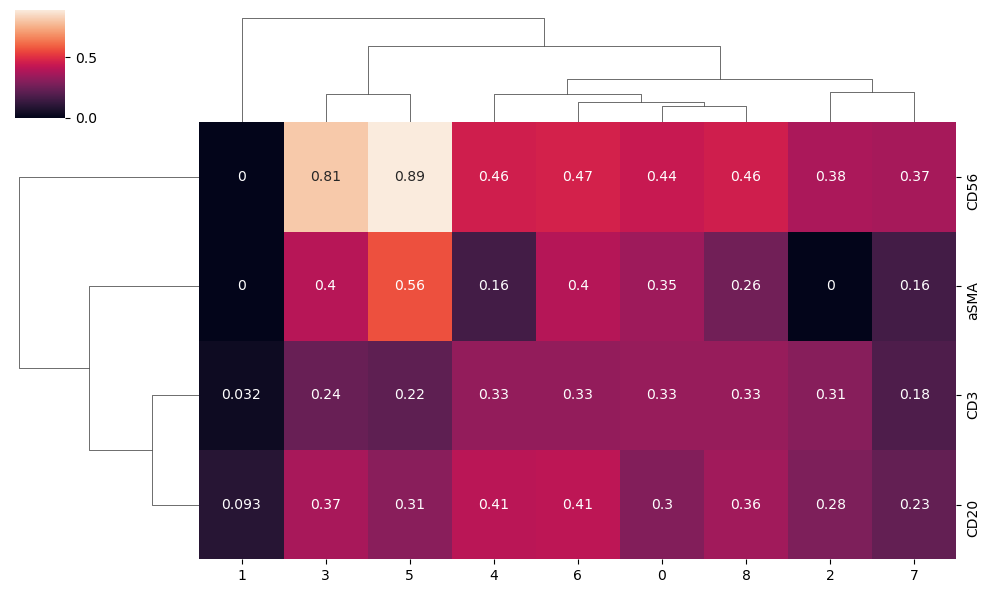

In [95]:
clusters = gmm.predict(mat)
means=pd.DataFrame(gmm.means_,columns=features_oi)

plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

<Figure size 640x480 with 0 Axes>

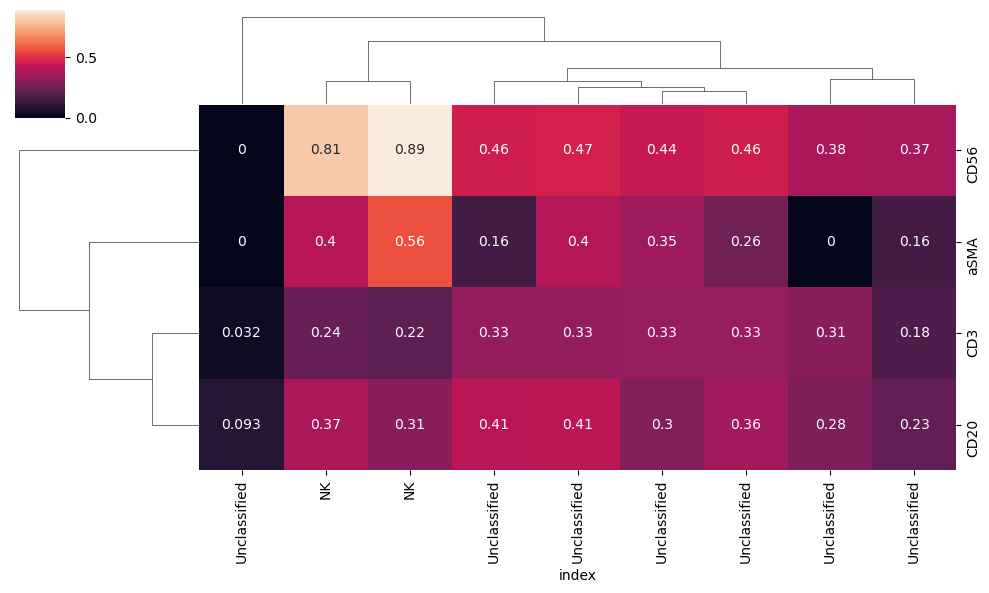

In [96]:
map_clusters={0:'Unclassified',
              1:'Unclassified',
              2:'Unclassified',
              3:'NK',
              4:'Unclassified',
              5:'NK',
              6:'Unclassified',
              7:'Unclassified',
              8:'Unclassified'
             }

means = means.reset_index()
means.index = means['index'].replace(map_clusters)
means = means.drop('index',axis=1)
plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

In [97]:
clusters_df=pd.DataFrame(clusters,index=df.index)[0].replace(map_clusters)
adata.obs.loc[clusters_df.index, 'major_pixel_type'] = clusters_df

<Axes: xlabel='major_pixel_type'>

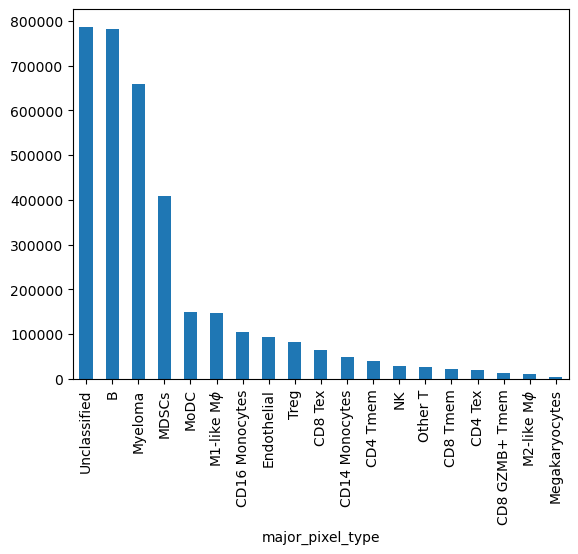

In [98]:
adata.obs['major_pixel_type'].value_counts().plot.bar()

## Unclassified again

In [101]:
n_components_range = range(2, 11)
covariance_types = ['full', 'tied', 'diag', 'spherical']
features_oi=['Collagen_type_I','aSMA','CD20','CD68','CD138','CD56','CD3']
pixel_type='Unclassified'
df=get_df_oi(adata,features_oi,pixel_type)[features_oi]
mat=df.values

In [102]:
gmm=GMMCluster.get_best_gmm(mat=mat,
                            n_components_range=n_components_range,
                            covariance_types=covariance_types,
                            plot=False)

<Figure size 640x480 with 0 Axes>

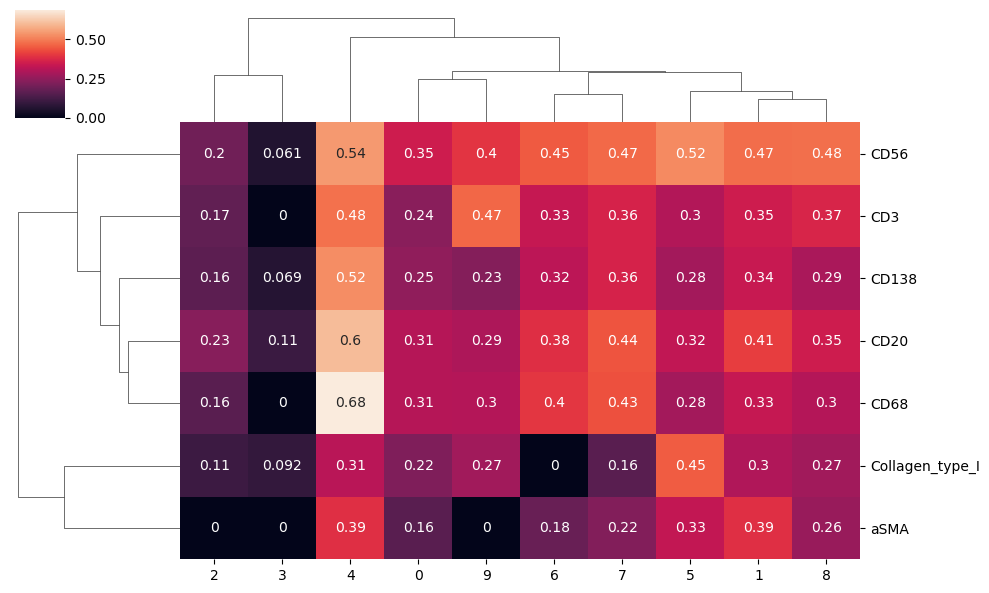

In [103]:
clusters = gmm.predict(mat)
means=pd.DataFrame(gmm.means_,columns=features_oi)

plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

<Figure size 640x480 with 0 Axes>

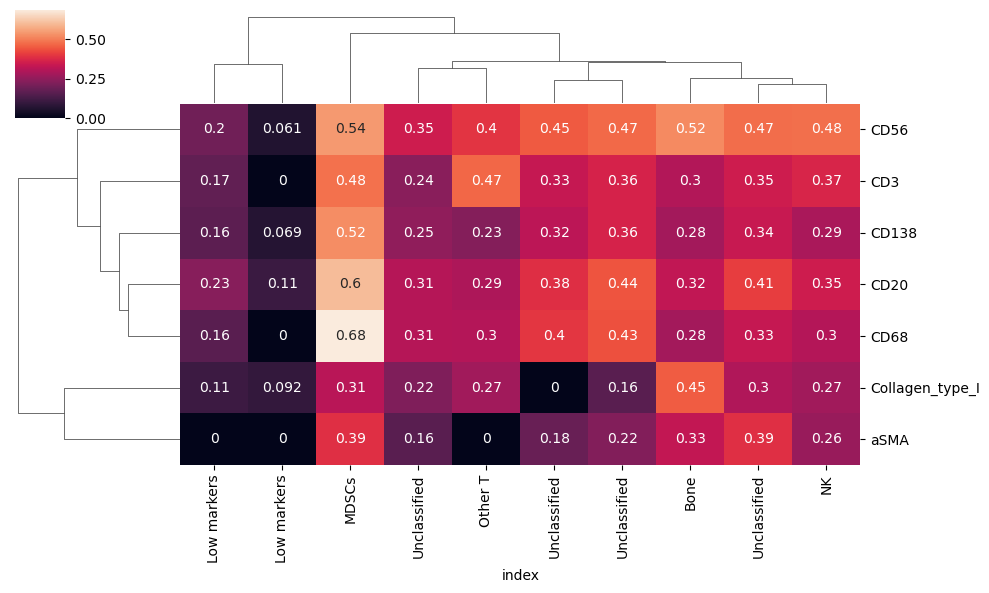

In [104]:
map_clusters={0:'Unclassified',
              1:'Unclassified',
              2:'Low markers',
              3:'Low markers',
              4:'MDSCs',
              5:'Bone',
              6:'Unclassified',
              7:'Unclassified',
              8:'NK',
              9:'Other T'
             }

means = means.reset_index()
means.index = means['index'].replace(map_clusters)
means = means.drop('index',axis=1)
plt.figure()
sns.clustermap(means.T, annot=True,col_cluster=True,figsize=(10, 6))
plt.show()

In [105]:
clusters_df=pd.DataFrame(clusters,index=df.index)[0].replace(map_clusters)
adata.obs.loc[clusters_df.index, 'major_pixel_type'] = clusters_df

<Axes: xlabel='major_pixel_type'>

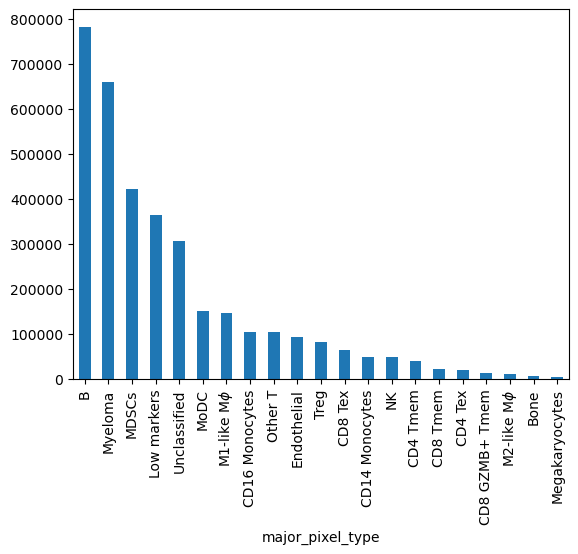

In [106]:
adata.obs['major_pixel_type'].value_counts().plot.bar()

In [110]:
df=sc.get.obs_df(adata, list(adata.var_names)+['major_pixel_type'],layer='exprs')

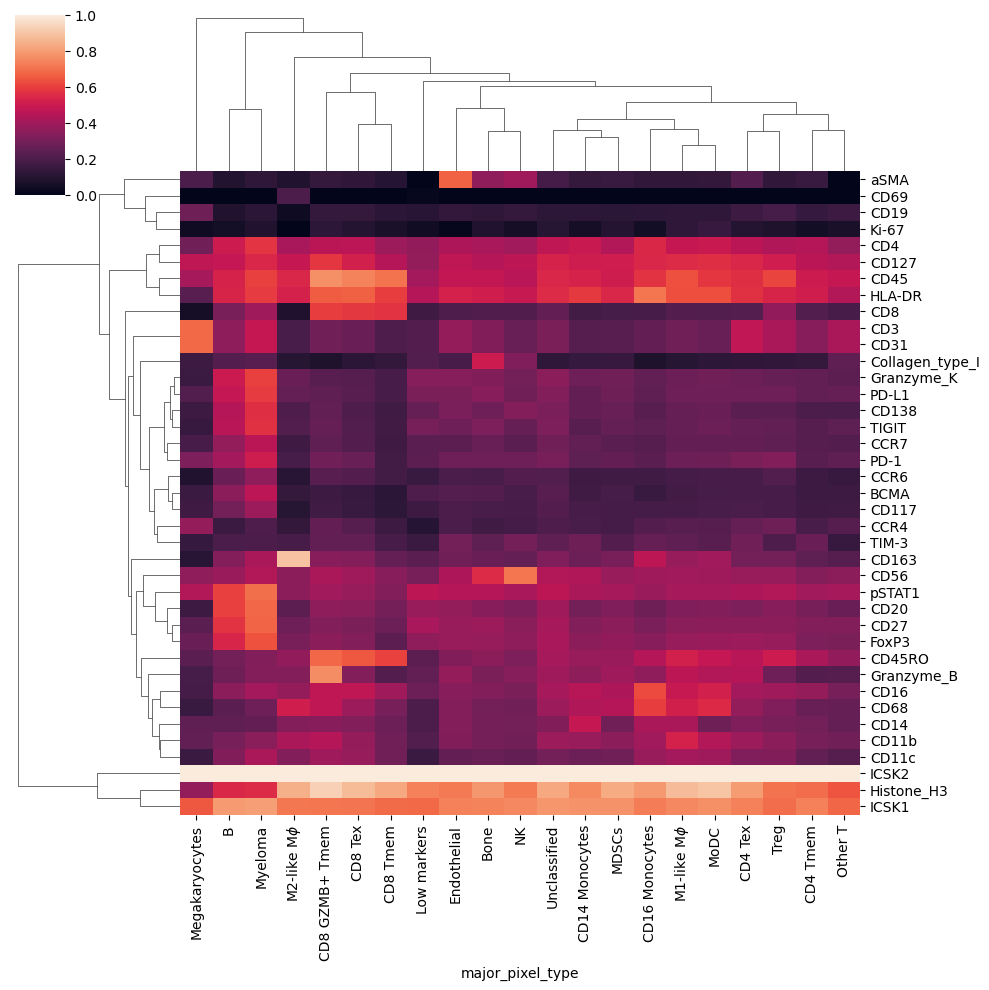

In [115]:
sns.clustermap(df.groupby('major_pixel_type').mean().T,standard_scale=1)

In [ ]:
adata.write('./samples/adata_annotated.h5ad')